In [ ]:
from typing import Tuple
import matplotlib.pyplot as plt
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
import os
import math
import numpy as np
import cv2
from waymo_open_dataset import dataset_pb2 as open_dataset
from waymo_open_dataset.wdl_limited.camera.ops import py_camera_model_ops

from waymo_open_dataset.protos import end_to_end_driving_data_pb2 as wod_e2ed_pb2
from waymo_open_dataset.protos import end_to_end_driving_submission_pb2 as wod_e2ed_submission_pb2
# Replace this path with your own tfrecords.
# This tutorial is based on using data in the E2E Driving proto format directly,
# so choose the correct dataset version.
DATASET_FOLDER = '/home/hansung/end2end_ad/datasets/waymo_open_dataset_end_to_end_camera_v_1_0_0' #Raw data tfrecord directory. Please modify
PREPROCESSED_DATA_FOLDER = '/home/hansung/OpenEMMA/qwen_results/openemma/' #Please modify
TRAIN_FILES = os.path.join(DATASET_FOLDER, "training_*.tfrecord-*")
VALIDATION_FILES = os.path.join(DATASET_FOLDER,"val_*.tfrecord-*")
TEST_FILES = os.path.join(DATASET_FOLDER, "test_*.tfrecord-*")

filenames = tf.io.matching_files(VALIDATION_FILES)
dataset = tf.data.TFRecordDataset(filenames, compression_type='')
dataset_iter = dataset.as_numpy_iterator()


In [ ]:
target_id = '0c8bd5520f4262ef6c37e79913c82e8d' #waymo uiud of the segment you wish to find. Must exist in the dataset
cur_id = ''
if target_id:
    while target_id not in cur_id:
        bytes_example = next(dataset_iter)
        data = wod_e2ed_pb2.E2EDFrame()
        data.ParseFromString(bytes_example)
        cur_id = data.frame.context.name
else:
    bytes_example = next(dataset_iter)
    data = wod_e2ed_pb2.E2EDFrame()
    data.ParseFromString(bytes_example)

In [ ]:
dir = PREPROCESSED_DATA_FOLDER + target_id + '/'
pred_traj = np.load(dir+'pred_xyz.npy')

In [43]:
def return_front3_cameras(data: wod_e2ed_pb2.E2EDFrame):
  """Return the front_left, front, and front_right cameras as a list of images"""
  image_list = []
  calibration_list = []
  # CameraName Enum reference:
  # https://github.com/waymo-research/waymo-open-dataset/blob/5f8a1cd42491210e7de629b6f8fc09b65e0cbe99/src/waymo_open_dataset/dataset.proto#L50
  order = [2, 1, 3]
  for camera_name in order:
    for index, image_content in enumerate(data.frame.images):
      if image_content.name == camera_name:
        # Decode the raw image string and convert to numpy type.
        calibration = data.frame.context.camera_calibrations[index]
        image = tf.io.decode_image(image_content.image).numpy()
        image_list.append(image)
        calibration_list.append(calibration)
        break

  return image_list, calibration_list

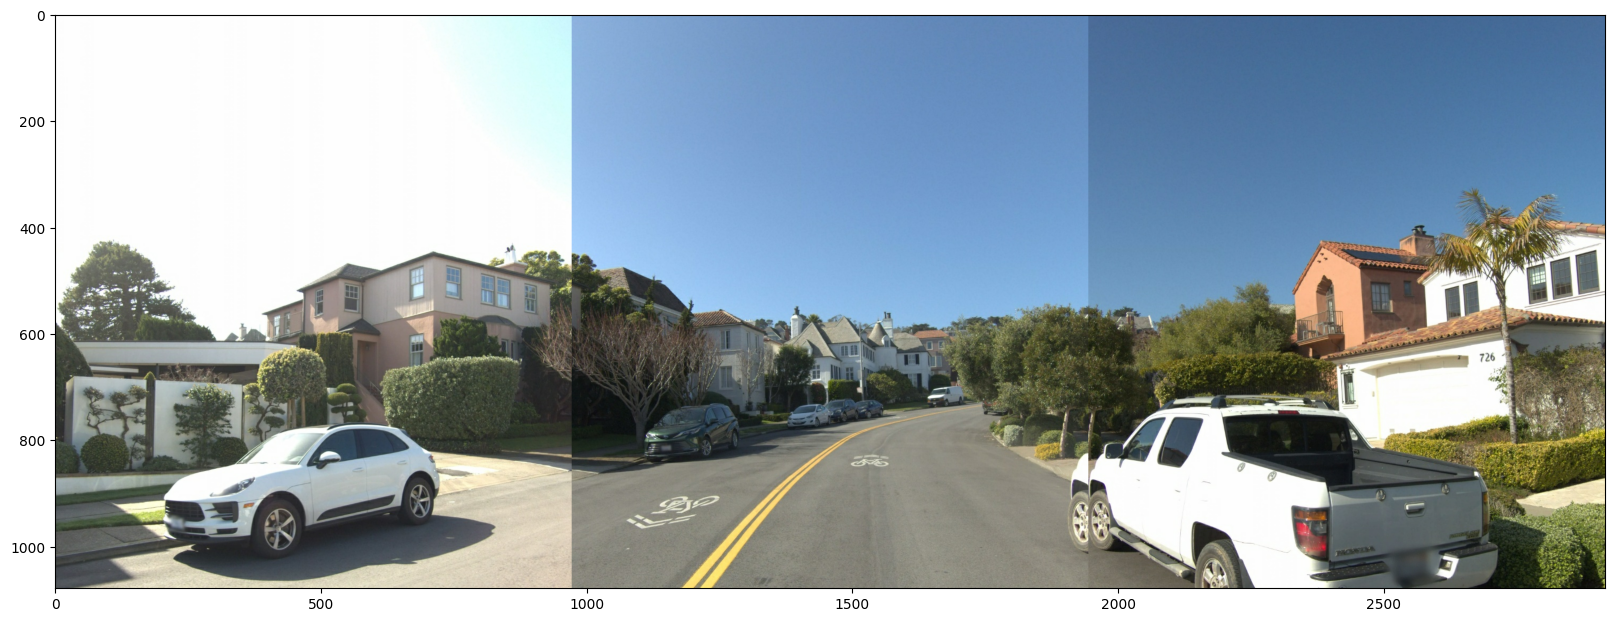

In [44]:
front3_camera_image_list, front3_camera_calibration_list = return_front3_cameras(data)
concatenated_image = np.concatenate(front3_camera_image_list, axis=1)
plt.figure(figsize=(20, 20))
plt.imshow(concatenated_image)

In [45]:
def project_vehicle_to_image(vehicle_pose, calibration, points):
  """Projects from vehicle coordinate system to image with global shutter.

  Arguments:
    vehicle_pose: Vehicle pose transform from vehicle into world coordinate
      system.
    calibration: Camera calibration details (including intrinsics/extrinsics).
    points: Points to project of shape [N, 3] in vehicle coordinate system.

  Returns:
    Array of shape [N, 3], with the latter dimension composed of (u, v, ok).
  """
  # Transform points from vehicle to world coordinate system (can be
  # vectorized).
  pose_matrix = np.array(vehicle_pose.transform).reshape(4, 4)
  world_points = np.zeros_like(points)
  for i, point in enumerate(points):
    cx, cy, cz, _ = np.matmul(pose_matrix, [*point, 1])
    world_points[i] = (cx, cy, cz)

  # Populate camera image metadata. Velocity and latency stats are filled with
  # zeroes.
  extrinsic = tf.reshape(
      tf.constant(list(calibration.extrinsic.transform), dtype=tf.float32),
      [4, 4])
  intrinsic = tf.constant(list(calibration.intrinsic), dtype=tf.float32)
  metadata = tf.constant([
      calibration.width,
      calibration.height,
      open_dataset.CameraCalibration.GLOBAL_SHUTTER,
  ],
                         dtype=tf.int32)
  camera_image_metadata = list(vehicle_pose.transform) + [0.0] * 10

  # Perform projection and return projected image coordinates (u, v, ok).
  return py_camera_model_ops.world_to_image(extrinsic, intrinsic, metadata,
                                            camera_image_metadata,
                                            world_points).numpy()

In [46]:
def draw_points_on_image(image, points, size=6, color='r'):
    h, w = image.shape[:2]
    rgb = (255, 0, 0) if color == 'r' else (0, 0, 255)

    for u, v, ok in points:
        if not bool(ok):
            continue
        u_i, v_i = int(round(u)), int(round(v))
        if 0 <= u_i < w and 0 <= v_i < h:
            cv2.circle(image, (u_i, v_i), size, rgb, -1)

    return image


In [47]:
future_waypoints_matrix = np.stack([data.future_states.pos_x, data.future_states.pos_y, data.future_states.pos_z], axis=1)
vehicle_pose = data.frame.images[0].pose

In [48]:
future_waypoints_matrix

array([[ 2.02783203e+00, -2.92968750e-02, -4.46319580e-03],
       [ 4.06054688e+00, -8.49609375e-02, -7.08007812e-03],
       [ 6.09619141e+00, -1.71875000e-01, -4.12750244e-03],
       [ 8.13378906e+00, -2.88574219e-01,  2.89916992e-04],
       [ 1.01777344e+01, -4.38964844e-01, -3.87573242e-03],
       [ 1.22192383e+01, -6.20605469e-01,  9.30786133e-04],
       [ 1.42622070e+01, -8.35937500e-01,  5.41687012e-03],
       [ 1.63076172e+01, -1.08349609e+00,  3.60870361e-03],
       [ 1.83525391e+01, -1.36230469e+00,  7.12585449e-03],
       [ 2.03920898e+01, -1.67236328e+00,  2.11715698e-02],
       [ 2.24287109e+01, -2.01367188e+00,  3.23715210e-02],
       [ 2.44638672e+01, -2.38769531e+00,  4.37011719e-02],
       [ 2.64848633e+01, -2.79150391e+00,  7.41500854e-02],
       [ 2.84985352e+01, -3.22705078e+00,  8.87756348e-02],
       [ 3.05048828e+01, -3.69628906e+00,  1.00784302e-01],
       [ 3.24995117e+01, -4.20019531e+00,  1.16203308e-01],
       [ 3.44868164e+01, -4.74169922e+00

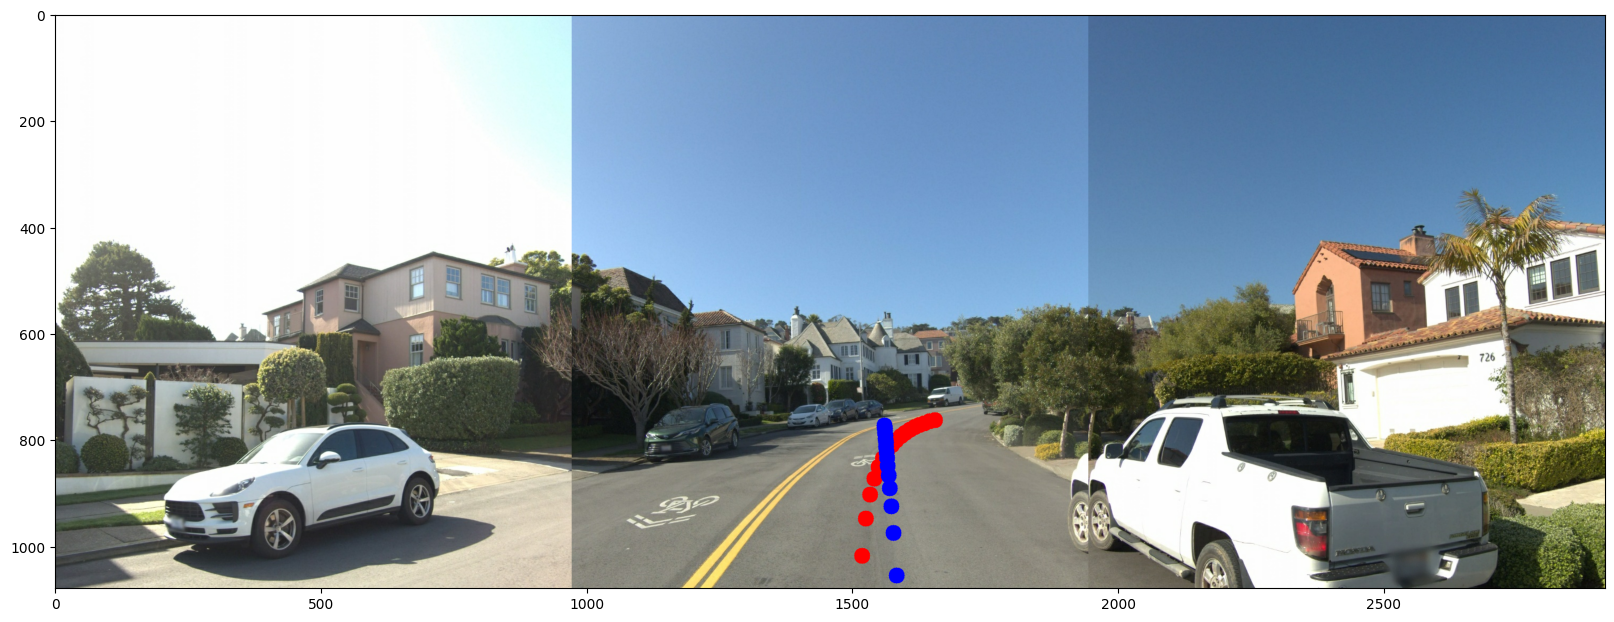

In [49]:
images_with_drawn_points = []
for i in range(len(front3_camera_calibration_list)):
  waypoints_camera_space = project_vehicle_to_image(vehicle_pose, front3_camera_calibration_list[i], future_waypoints_matrix)
  waypoints_generated = project_vehicle_to_image(vehicle_pose, front3_camera_calibration_list[i], pred_traj)
  img = draw_points_on_image(front3_camera_image_list[i], waypoints_camera_space, size=15)
  images_with_drawn_points.append(draw_points_on_image(img, waypoints_generated, size=15,color='b'))
  # images_with_drawn_points.append()

concatenated_image = np.concatenate(images_with_drawn_points, axis=1)
plt.figure(figsize=(20, 20))
plt.imshow(concatenated_image)

# Submission Generation:
we look at the ```waymo_testing_segments.json``` to retreive a list of sgement ids to look for in our results folder

In [ ]:
import json
with open('waymo_testing_segments.json', 'r') as f:
    segments_json = json.load(f) # Reads and parses JSON from a fil

In [ ]:
predictions = []
processed_id = set()
results_folder = 'qwen_results/openemma/testing/' #please modify
for id in segments_json.keys():
    if id not in processed_id:
        dir = results_folder + id + '/'
        try:
            pred_traj = np.load(dir+'pred_xyz.npy')
        except:
            print(id,' not found')
            continue
        predicted_trajectory = wod_e2ed_submission_pb2.TrajectoryPrediction(pos_x=pred_traj[:20,0],
                                                                            pos_y=pred_traj[:20,1])
        frame_name = id + '-' + segments_json[id][-1]
        frame_trajectory = wod_e2ed_submission_pb2.FrameTrajectoryPredictions(frame_name=frame_name, trajectory=predicted_trajectory)
        # The final prediction should be a list of FrameTrajectoryPredictions.
        predictions.append(frame_trajectory)
        processed_id.add(id)

bccfb8fa509a4ed797a02d3c077f2f8f  not found
b4f1a608ec4505202abce645f982622a  not found
5e96956d508277b0fab2b9a2b7d3861c  not found
66a5e42d9be3e1d31af149ed09d935ea  not found
33e84c1d2a04acf0a8204f1869999a31  not found
d600bc62033ff5a314165170a3cec788  not found
4baf90b8cefc39fe888fe234eeffd1ce  not found
d91612e38087175ebd9205514f7895e5  not found
9be9f1962be7b050ee653be0561688d1  not found
4093f68dacf0d7e20ee1e4c106fecd18  not found
2bda1b4efc75942d886dda0b54345c49  not found
fcd03855bad5f18169c06047ffc85072  not found
cc04d1b294c5c373b607f19193e46ea0  not found
d4f544d65ff0143e4323be29e6fd4fb3  not found
1eb56ede77749bd7e048c11c258f25d1  not found
63478e270a64b1d47ead69aec3730ec7  not found
a54ba370aa3b825db8d6d6917584d225  not found
3d9e90db3c1ed99ad2fefbb2ba650cdb  not found
cec37a7b259e45636117b5dcd7140fe7  not found
4141a5fba8d5817bcb78543701c54ecc  not found
b4c281adebaa6596a031d1e1f973e3bc  not found
079157c0f9b64500e2e498473973c2e2  not found
7fe07153de52017998ea488bfbb46eed

In [67]:
# Pack for submission.
num_submission_shards = 1  # Please modify accordingly.
submission_file_base = '/home/hansung/OpenEMMA/submission'  # Please modify accordingly.
if not os.path.exists(submission_file_base):
  os.makedirs(submission_file_base)
sub_file_names = [
    os.path.join(submission_file_base, part)
    for part in [f'mysubmission.binproto-00000-of-00001' for i in range(num_submission_shards)]
]
# As the submission file may be large, we shard them into different chunks.
submissions = []
num_predictions_per_shard =  math.ceil(len(predictions) / num_submission_shards)
for i in range(num_submission_shards):
  start = i * num_predictions_per_shard
  end = (i + 1) * num_predictions_per_shard
  submissions.append(
      wod_e2ed_submission_pb2.E2EDChallengeSubmission(
          predictions=predictions[start:end]))

In [68]:
for i, shard in enumerate(submissions):
  shard.submission_type  =  wod_e2ed_submission_pb2.E2EDChallengeSubmission.SubmissionType.E2ED_SUBMISSION
  shard.authors[:] = ['Hansung Kim']  # Please modify accordingly.
  shard.affiliation = 'University of California, Berkeley'  # Please modify accordingly.
  shard.account_name = 'hansung@berkeley.edu'  # Please modify accordingly.
  shard.unique_method_name = 'OpenEMMA w/ QwenVLM'  # Please modify accordingly.
  shard.method_link = 'method_link'  # Please modify accordingly.
  shard.description = 'Open source implementation of EMMA (Waymo, adopted: https://github.com/taco-group/OpenEMMA) using Qwen-VLM queries'  # Please modify accordingly.
  shard.uses_public_model_pretraining = True # Please modify accordingly.
  shard.public_model_names.extend(['Qwen2-VL-7B-Instruct']) # Please modify accordingly.
  shard.num_model_parameters = "7B" # Please modify accordingly.
  with tf.io.gfile.GFile(sub_file_names[i], 'wb') as fp:
    fp.write(shard.SerializeToString())